In [1]:
from ultralytics import YOLO
import os
import pydicom
import matplotlib.pyplot as plt

In [2]:
model = YOLO("yolo/yolov11 40 epochs2/weights/best.pt")
model.eval()
print('YOLO loaded')

YOLO loaded


In [3]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [4]:
def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [7]:
dicom_images

['21.dcm',
 '22.dcm',
 '23.dcm',
 '24.dcm',
 '25.dcm',
 '27.dcm',
 '30.dcm',
 '33.dcm',
 '35.dcm',
 '36.dcm',
 '39.dcm',
 '40.dcm',
 '43.dcm',
 '44.dcm',
 '45.dcm',
 '47.dcm',
 '48.dcm',
 '54.dcm',
 '57.dcm',
 '61.dcm',
 '62.dcm',
 '63.dcm',
 '64.dcm',
 '68.dcm',
 '71.dcm',
 '72.dcm',
 '77.dcm',
 '73.dcm',
 '81.dcm',
 '86.dcm',
 '95.dcm',
 '96.dcm',
 '97.dcm',
 '98.dcm',
 '99.dcm',
 '100.dcm',
 '101.dcm',
 '102.dcm',
 '103.dcm',
 '104.dcm',
 '105.dcm',
 '106.dcm',
 '107.dcm',
 '108.dcm',
 '111.dcm',
 '112.dcm',
 '113.dcm',
 '115.dcm',
 '116.dcm',
 '117.dcm',
 '118.dcm',
 '120.dcm',
 '119.dcm',
 '121.dcm',
 '122.dcm',
 '123.dcm',
 '125A.dcm',
 '126.dcm',
 '125B.dcm',
 '127.dcm',
 '128.dcm',
 '129.dcm',
 '130.dcm',
 '131.dcm',
 '132.dcm',
 '133.dcm',
 '134.dcm',
 '135.dcm',
 '136.dcm',
 '137.dcm',
 '138.dcm',
 '140.dcm',
 '139.dcm',
 '141.dcm',
 '142.dcm',
 '143.dcm',
 '144.dcm',
 '145.dcm',
 '146.dcm',
 '147.dcm',
 '148.dcm',
 '149.dcm',
 '150.dcm',
 '151.dcm',
 '152.dcm',
 '153.dcm',
 


0: 480x1120 1 ulnar, 7.3ms
Speed: 3.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)
542 61 723 135


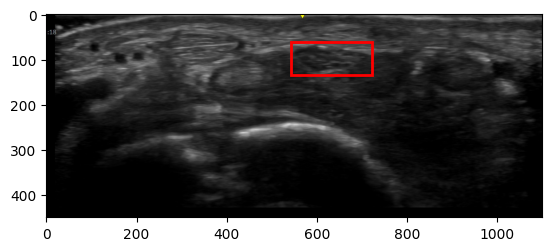

In [11]:
dicom_images = os.listdir(dicom_dir)

# for i in range(len(dicom_images)):
filename = '33.dcm'
dicom_path = os.path.join(dicom_dir, filename)
dicom_img = load_dicom(dicom_path)
result = model(dicom_img, save=False, save_txt=False, save_conf=False)

plt.imshow(dicom_img, cmap='gray')
box = result[0].boxes[0]
x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
print(x1, y1, x2, y2)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none', linewidth=2))
plt.show()


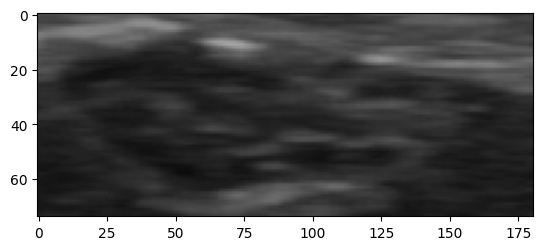

In [12]:

plt.imshow(dicom_img[y1:y2, x1:x2], cmap='gray')

In [14]:
anno_path = os.path.join(anno_dir, '33.nii.gz')
import SimpleITK as sitk
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

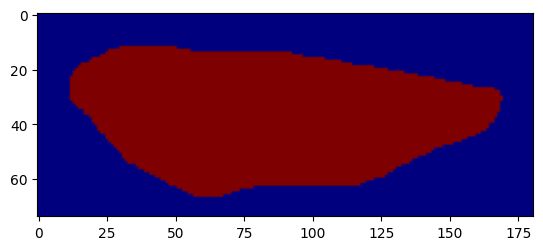

In [17]:
plt.imshow(load_mask(anno_path)[y1:y2, x1:x2], cmap='jet')

In [10]:
import pandas as pd
import os
df = pd.read_excel('/data_vault/hexai02/CarpalTunnel/AI Project Data Clean 10-8.xlsx')

In [12]:
df['Clinical Signs of CTS'] = df['Clinical Signs of CTS'].replace('Yes', 'Y')
df = df[df['Clinical Signs of CTS'] != '?']
df['Number'] = df['Number'].astype(str)

In [13]:
df['Clinical Signs of CTS'].value_counts()

Clinical Signs of CTS
Y    73
N    48
Name: count, dtype: int64

In [17]:
df.columns

Index(['Number', 'WristImage Segmentation for AI Analysis', 'Arm (L/R)', 'Sex',
       'Race', 'Ethnicity', 'Age', 'Clinical Signs of CTS', 'CTS-6 Score',
       'Measurement at Wrist'],
      dtype='object')

In [11]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

## make these directories
os.makedirs(restructured_root, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)
os.makedirs(image_train_dir, exist_ok=True)
os.makedirs(image_val_dir, exist_ok=True)
os.makedirs(image_test_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)
os.makedirs(label_train_dir, exist_ok=True)
os.makedirs(label_val_dir, exist_ok=True)

In [8]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [26]:
counts = [0, 0]  # [Y count, N count]

for i, file_jpg in enumerate(os.listdir(image_train_dir)):
    file_name = file_jpg.split('.')[0]
    
    matched = df.loc[df['Number'] == file_name, 'Clinical Signs of CTS']
    
    if matched.empty:
        continue  # Skip if no match found
    
    cts_value = matched.values[0]
    
    if cts_value == 'Y':
        counts[0] += 1
    elif cts_value == 'N':
        counts[1] += 1
    # No else needed, unknowns are ignored

print(f"Y: {counts[0]}, N: {counts[1]}")


Y: 65, N: 35


In [25]:
counts

[55, 31]